# 训练情感分类器

这是[深圳技术大学2025秋季微专业课](https://hqyang.github.io/nlp-codes/)使用的Jupyter Notebook。下面尝试基于数据进行训练。具体来说，它使用词袋提取特征，并使用多项式逻辑回归算法训练分类器。

它将接收文本`X`并返回一个`标签`，如果文本的情感类型是积极的，则为“1”，如果文本的情感类型是消极的，则为“-1”，如果文本的情感类型是中性的，则为“0”。
你可以在[Stanford Sentiment Treebank](http://nlp.stanford.edu/sentiment/index.html)运行此脚本测试你的分类器的准确性。 

In [11]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Implement MultinomialLogisticRegression

In [12]:
class MultinomialLogisticRegression:
    def __init__(self, batch_size=32, learning_rate=0.01, reg_param=0.01, epochs=100):
        """
        初始化多项式逻辑回归模型（多分类）
        :param batch_size: 批处理大小
        :param learning_rate: 学习率
        :param reg_param: L2正则化参数
        :param epochs: 训练轮数
        """
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.reg_param = reg_param
        self.epochs = epochs
        self.vocab = None  # 词汇表（词→索引）
        self.classes = None  # 类别列表
        self.W = None  # 权重矩阵 (特征数 + 1, 类别数)，+1为偏置项
        self.train_losses = []  # 记录训练损失
        self.train_accs = []  # 记录训练准确率
        self.val_losses = []  # 记录验证损失
        self.val_accs = []  # 记录验证准确率

    def _extract_features(self, text):
        """提取单个文本的词频特征"""
        features = defaultdict(int)
        for word in text.split():
            features[word] += 1

        # Implement your feature extraction logic here
        # 建议: 简单的词袋模型：按空格分词并计数
        pass
    
        return features

    def _build_vocab(self, texts):
        """从训练文本构建词汇表"""
        vocab = {}
        for text in texts:
            for word in text.split():
                if word not in vocab:
                    vocab[word] = len(vocab)

        # Implement your vocabulary building logic here
        # 建议: 遍历所有文本，按出现顺序为每个唯一词分配索引
        pass

        return vocab

    def _texts_to_matrix(self, texts):
        """将文本列表转换为词频矩阵（添加偏置项）"""
        if not self.vocab:
            raise ValueError("词汇表未初始化，请先训练模型")
        
        n_samples = len(texts)
        n_features = len(self.vocab)
        # 初始化矩阵（+1用于偏置项）
        X = np.zeros((n_samples, n_features + 1))
        X[:, 0] = 1.0  # 第0列固定为1（偏置项）

        # Implement your text to matrix conversion logic here
        # 建议: 对每个文本，提取词频特征并填充矩阵
        pass        

        return X

    def _softmax(self, z):
        """稳定版softmax函数（避免数值溢出）"""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _cross_entropy_loss(self, y_pred, y_true):
        """计算交叉熵损失"""
        n_samples = y_pred.shape[0]
        log_likelihood = -np.log(y_pred[range(n_samples), y_true] + 1e-15)
        loss = np.sum(log_likelihood) / n_samples
        # 添加L2正则化项
        loss += (self.reg_param / 2) * np.sum(self.W[1:, :] ** 2)  # 不正则化偏置项
        return loss

    def fit(self, X_train_text, y_train, X_val_text=None, y_val=None):
        """
        训练模型
        :param X_train_text: 训练文本列表
        :param y_train: 训练标签列表
        :param X_val_text: 验证文本列表（可选）
        :param y_val: 验证标签列表（可选）
        """
        # 1. 构建词汇表和类别映射
        self.vocab = self._build_vocab(X_train_text)
        self.classes = np.unique(y_train)
        n_classes = len(self.classes)
        n_features = len(self.vocab)
        
        # 2. 转换文本为特征矩阵（含偏置项）
        X_train = self._texts_to_matrix(X_train_text)
        # 将标签映射为0~n_classes-1（便于one-hot处理）
        y_train_mapped = np.array([np.where(self.classes == y)[0][0] for y in y_train])
        
        # 3. 初始化权重矩阵（随机初始化）
        self.W = np.random.randn(n_features + 1, n_classes) * 0.01  # +1是偏置项
        
        # 4. 小批量梯度下降训练
        n_samples = X_train.shape[0]
        for epoch in tqdm(range(self.epochs), desc="Training"):
            # 打乱训练数据
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train_mapped[indices]
            
            # 按批次更新
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                # 前向传播：计算预测概率
                # Implement your forward propagation logic here
                z = X_batch @ self.W
                y_pred = self._softmax(z)
                # 计算梯度（含正则化）
                # Implement your gradient computation logic here
                n_batch = X_batch.shape[0]
                y_one_hot = np.zeros_like(y_pred)
                y_one_hot[np.arange(n_batch), y_batch] = 1
                gradient = (X_batch.T @ (y_pred - y_one_hot)) / n_batch
                # 添加正则化梯度（不正则化偏置项）
                gradient[1:, :] += self.reg_param * self.W[1:, :]
                
                # 更新权重
                # Implement your weight update logic here
                self.W -= self.learning_rate * gradient
            
            # 记录当前epoch的损失和准确率
            # 训练集指标
            z_train = X_train @ self.W
            y_pred_train = self._softmax(z_train)
            train_loss = self._cross_entropy_loss(y_pred_train, y_train_mapped)
            train_acc = np.mean(np.argmax(y_pred_train, axis=1) == y_train_mapped)
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            
            # 验证集指标（如果提供）
            if X_val_text is not None and y_val is not None:
                X_val = self._texts_to_matrix(X_val_text)
                y_val_mapped = np.array([np.where(self.classes == y)[0][0] for y in y_val])
                z_val = X_val @ self.W
                y_pred_val = self._softmax(z_val)
                val_loss = self._cross_entropy_loss(y_pred_val, y_val_mapped)
                val_acc = np.mean(np.argmax(y_pred_val, axis=1) == y_val_mapped)
                self.val_losses.append(val_loss)
                self.val_accs.append(val_acc)
            
            # 每10轮打印一次进度
            if (epoch + 1) % 10 == 0:
                log = f"Epoch {epoch+1}/{self.epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}"
                if X_val_text is not None:
                    log += f" | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
                print(log)

    def predict(self, texts):
        """预测文本类别"""
        X = self._texts_to_matrix(texts)
        z = X @ self.W
        y_pred_mapped = np.argmax(self._softmax(z), axis=1)
        return self.classes[y_pred_mapped]

    def score(self, texts, labels):
        """计算准确率"""
        y_pred = self.predict(texts)
        return np.mean(y_pred == labels)

    def plot_convergence(self):
        """绘制训练/验证的损失和准确率收敛曲线"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # 损失曲线
        ax1.plot(range(1, self.epochs + 1), self.train_losses, label="Train Loss")
        if self.val_losses:
            ax1.plot(range(1, self.epochs + 1), self.val_losses, label="Val Loss")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        ax1.set_title("Loss Convergence")
        ax1.legend()
        ax1.grid(True)
        
        # 准确率曲线
        ax2.plot(range(1, self.epochs + 1), self.train_accs, label="Train Accuracy")
        if self.val_accs:
            ax2.plot(range(1, self.epochs + 1), self.val_accs, label="Val Accuracy")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Accuracy")
        ax2.set_title("Accuracy Convergence")
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

In [13]:
# 1. 数据读取函数（复用之前的逻辑）
def read_xy_data(filename):
    x_data = []
    y_data = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            label, text = line.split(' ||| ')
            x_data.append(text)
            y_data.append(int(label))
    return x_data, y_data

In [14]:
# 2. 加载数据
x_train, y_train = read_xy_data('../data/sst-sentiment-text-threeclass/train.txt')
x_dev, y_dev = read_xy_data('../data/sst-sentiment-text-threeclass/dev.txt')

print(f"训练集样本数: {len(x_train)}")
print(f"验证集样本数: {len(x_dev)}")

print(x_train[0])
print(y_train[0])

训练集样本数: 8544
验证集样本数: 1101
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
1


Training:  20%|██        | 10/50 [00:09<00:38,  1.05it/s]

Epoch 10/50 | Train Loss: 1.2184 | Train Acc: 0.4225 | Val Loss: 1.2259 | Val Acc: 0.4033


Training:  40%|████      | 20/50 [00:19<00:29,  1.02it/s]

Epoch 20/50 | Train Loss: 1.1436 | Train Acc: 0.4225 | Val Loss: 1.1545 | Val Acc: 0.4033


Training:  60%|██████    | 30/50 [00:36<00:37,  1.89s/it]

Epoch 30/50 | Train Loss: 1.1027 | Train Acc: 0.4225 | Val Loss: 1.1153 | Val Acc: 0.4033


Training:  80%|████████  | 40/50 [00:53<00:17,  1.77s/it]

Epoch 40/50 | Train Loss: 1.0794 | Train Acc: 0.4225 | Val Loss: 1.0929 | Val Acc: 0.4033


Training: 100%|██████████| 50/50 [01:12<00:00,  1.44s/it]

Epoch 50/50 | Train Loss: 1.0659 | Train Acc: 0.4225 | Val Loss: 1.0798 | Val Acc: 0.4033



Train Accuracy: 0.4225
Dev/Test Accuracy: 0.4033


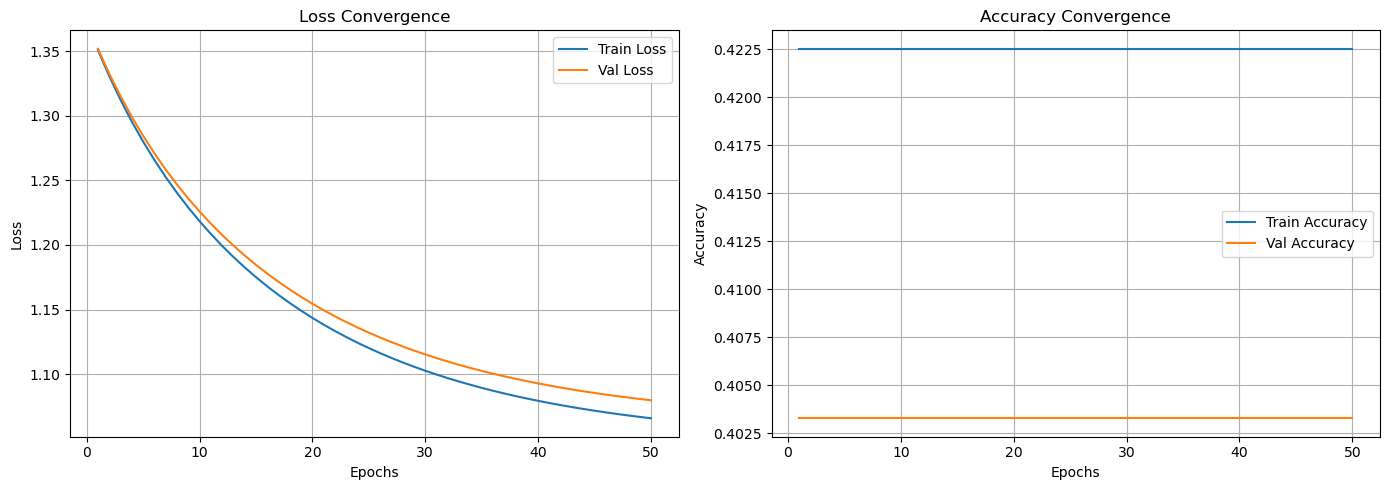

In [15]:
# 示例：情感分类任务测试
if __name__ == "__main__":
    # 初始化并训练模型
    model = MultinomialLogisticRegression(
        batch_size=32,
        learning_rate=0.001,
        reg_param=0.1,
        epochs=50
    )
    model.fit(x_train, y_train, X_val_text=x_dev, y_val=y_dev)

    # 4. 评估模型
    train_acc = model.score(x_train, y_train)
    dev_acc = model.score(x_dev, y_dev)
    print(f"\nTrain Accuracy: {train_acc:.4f}")
    print(f"Dev/Test Accuracy: {dev_acc:.4f}")

    # 5. 绘制收敛曲线
    model.plot_convergence()